## GAEZ show

Firefox works better for navigating and downloading data from [FAO's GAEZ](http://gaez.fao.org/Main.html)

In the example below I've downloaded data on "Crop suitability index (class) for high input level rain-fed cereals".  We use the .tif file inside the downloaded zip file. Here is a screenshot of the GAEZ web page (also showing the legend):

![](GAEZCapture.PNG)


In [1]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import rasterio
import rasterio.plot
from rasterstats import zonal_stats

#### Plot the raster over countries map

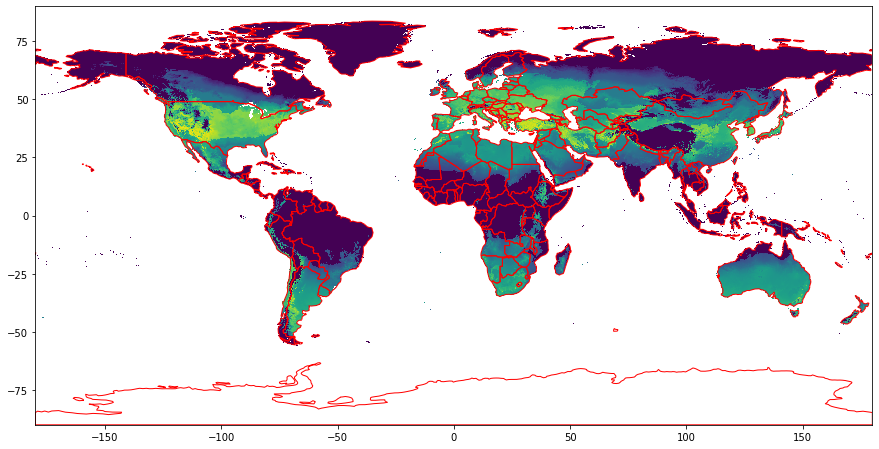

In [2]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
raster = rasterio.open("res02_crav6190h_whea000a_yld.tif")

fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(raster, ax=ax)
countries.plot(ax=ax, facecolor='none', edgecolor='red');

This raster has one band:

In [3]:
raster.count

1

In [4]:
raster.width, raster.height

(4320, 2160)

In [5]:
raster.bounds

BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)

In [6]:
raster.transform

Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0)

From [rasterio docs](https://rasterio.readthedocs.io/en/stable/quickstart.html): A dataset’s transform is an affine transformation matrix that maps pixel locations in (row, col) coordinates to (x, y) spatial positions. The product of this matrix and (0, 0), the row and column coordinates of the upper left corner of the dataset, is the spatial position of the upper left corner.

In [7]:
raster.transform * (0,0)

(-180.0, 90.0)

In [8]:
raster.crs

CRS.from_dict(init='epsg:4326')

In [9]:
band1 = raster.read(1)

In [10]:
band1.shape

(2160, 4320)

In [11]:
band1

array([[-9, -9, -9, ..., -9, -9, -9],
       [-9, -9, -9, ..., -9, -9, -9],
       [-9, -9, -9, ..., -9, -9, -9],
       ...,
       [-9, -9, -9, ..., -9, -9, -9],
       [-9, -9, -9, ..., -9, -9, -9],
       [-9, -9, -9, ..., -9, -9, -9]], dtype=int16)

We can pick out the value at any given position (here the point in the middle of the box):

In [12]:
band1[raster.height//2,raster.width//2]

-9

In [13]:
type(band1)

numpy.ndarray

Note the values seem to range from 0 to 13356. So I'm not sure how this matches up to the GAEZ legend above.

In [14]:
np.unique(band1)

array([   -9,     0,   695, ..., 13245, 13285, 13356], dtype=int16)

## Country zonal statistics
Using `rasterstats`

In [15]:
zstats = pd.DataFrame(zonal_stats(countries, "res02_crav6190h_whea000a_yld.tif",
            stats="count min mean max median"))

In [16]:
zstats.head(2)

,count,max,mean,median,min
0,9147,12545.0,8044.844976,9085.0,0.0
1,14842,9340.0,4138.276176,4855.0,0.0


Let us merge this information into the original countries dataframe (merge using index).

In [18]:
countries = countries.merge(zstats, how='outer',left_index=True, right_index=True)
countries.head(3)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,count,max,mean,median,min
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,...",9147,12545.0,8044.844976,9085.0,0.0
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...,14842,9340.0,4138.276176,4855.0,0.0
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,...",455,11952.0,9433.760440,10100.0,0.0


This is a quick and dirty choropleth map using geopandas where countries have been classified by their median soil (note USA, Argentina, France, Italy and Ukraine among others get picked out as having high Wheat yield potential.

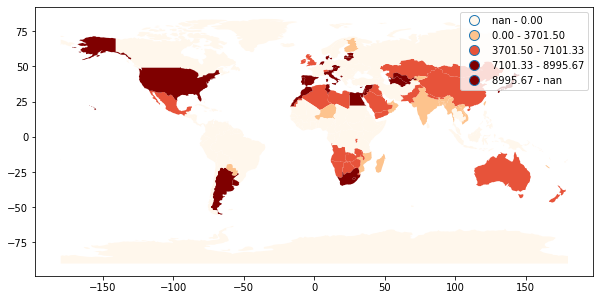

In [21]:
countries.plot(column='median',legend=True, 
               cmap='OrRd',
               scheme='quantiles', k=6,
               figsize=(10,10));

In [20]:
countries['mean'].describe()

count      175.000000
mean      4261.732578
std       3680.717531
min          0.000000
25%        304.446707
50%       3772.746562
75%       7638.327635
max      10763.926126
Name: mean, dtype: float64